In [10]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import cloudpickle
import dill
import os
import warnings

# settings
SESSION_FILE = "variables.session"
def save_session():
    dill.dump_session(SESSION_FILE)
    print(f"Session saved to {SESSION_FILE}")
def load_session():
    if os.path.exists(SESSION_FILE):
        dill.load_session(SESSION_FILE)
        print(f"Session loaded from {SESSION_FILE}")
    else:
        print("No saved session found.")
warnings.filterwarnings("ignore")

In [ ]:
# load everything
load_session()

In [12]:
# load dataset
data = pd.read_csv("powerconsumption.csv")
data.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [13]:
# data backup
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [14]:
# change datatype of datetime
df['Datetime'] = pd.to_datetime(df['Datetime'], format= '%Y-%m-%d %H:%M:%S')
df.set_index('Datetime', inplace= True)
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [15]:
# duplicates
df.drop_duplicates(inplace= True)
print(f"no of rows reduced to {df.shape[0]}")

no of rows reduced to 52416


In [16]:
# null values
df.isnull().sum()

Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [17]:
# outliers
df.describe()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


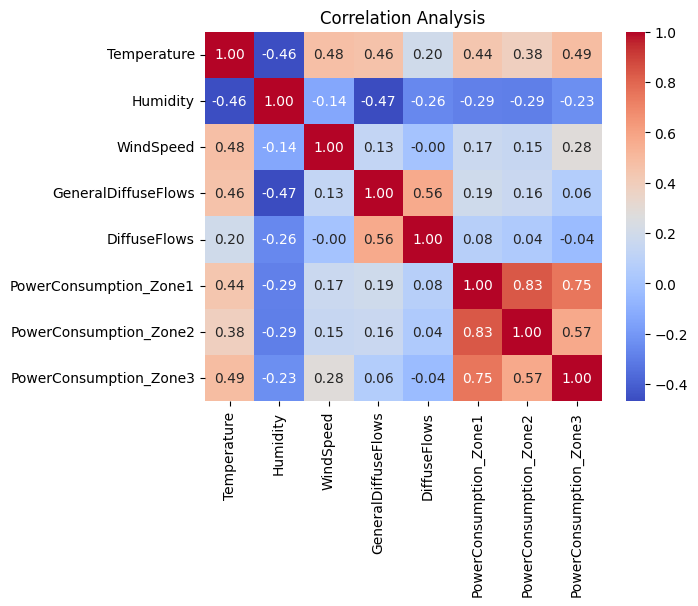

In [18]:
# correlation analysis
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Analysis")
plt.show()

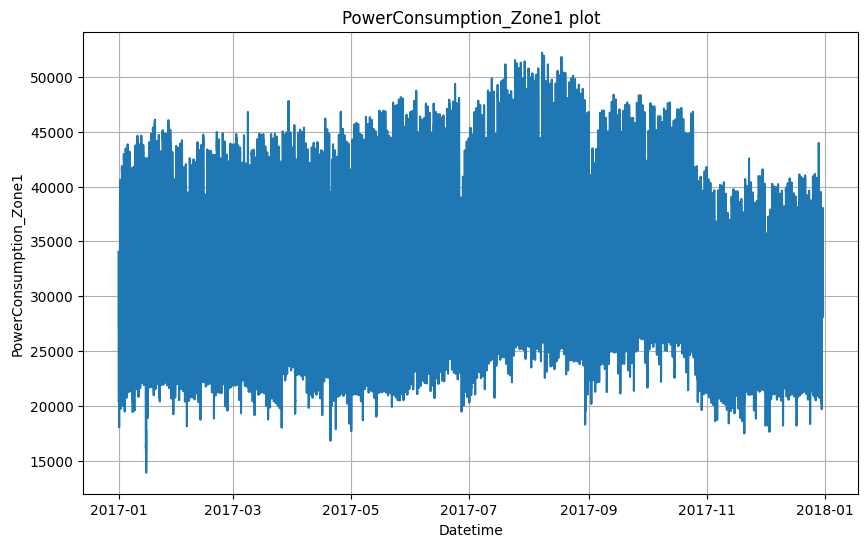

In [19]:
# plot orginal 
plt.figure(figsize= (10,6))
plt.plot(df['PowerConsumption_Zone1'])
plt.xlabel('Datetime')
plt.ylabel('PowerConsumption_Zone1')
plt.title('PowerConsumption_Zone1 plot')
plt.grid()

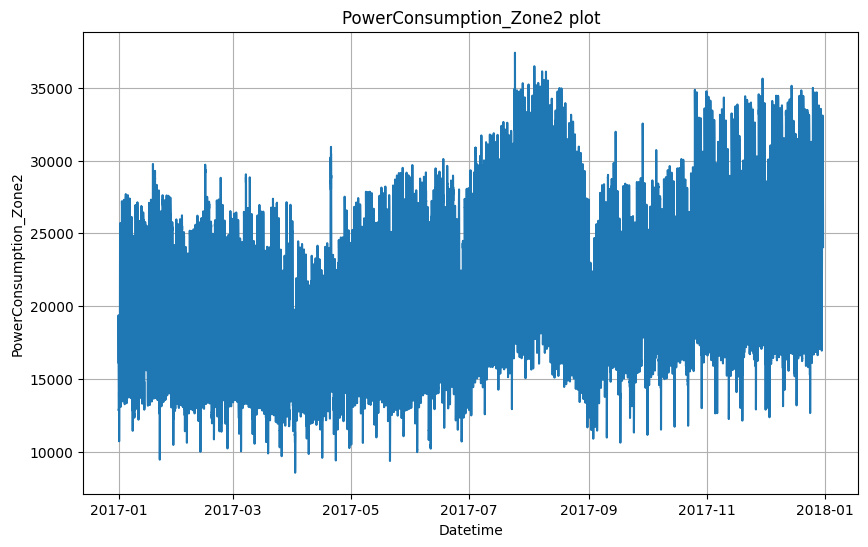

In [20]:
# plot orginal 
plt.figure(figsize= (10,6))
plt.plot(df['PowerConsumption_Zone2'])
plt.xlabel('Datetime')
plt.ylabel('PowerConsumption_Zone2')
plt.title('PowerConsumption_Zone2 plot')
plt.grid()

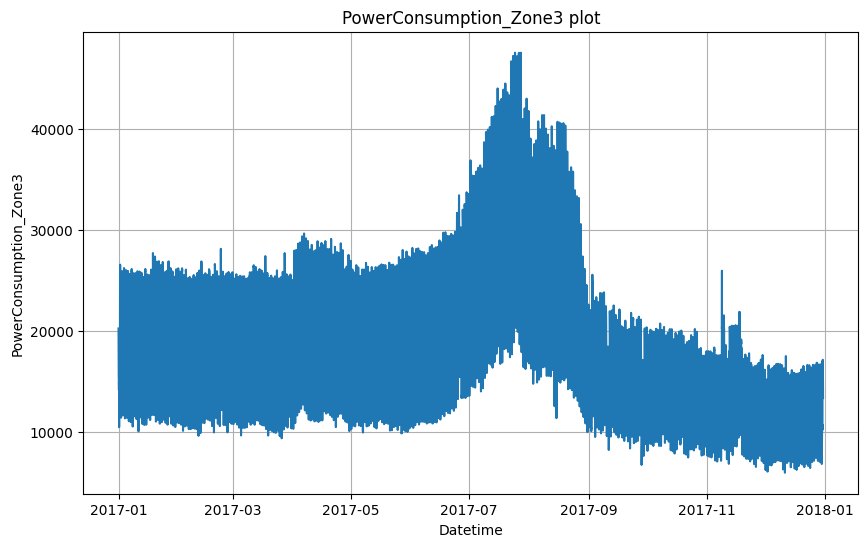

In [21]:
# plot orginal 
plt.figure(figsize= (10,6))
plt.plot(df['PowerConsumption_Zone3'])
plt.xlabel('Datetime')
plt.ylabel('PowerConsumption_Zone3')
plt.title('PowerConsumption_Zone3 plot')
plt.grid()

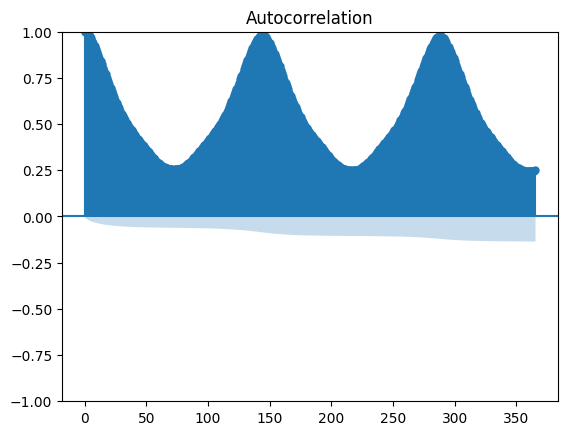

In [22]:
# find seasonality
plot_acf(df['PowerConsumption_Zone3'], lags=365)
plt.show()  # expected seasonality = 144

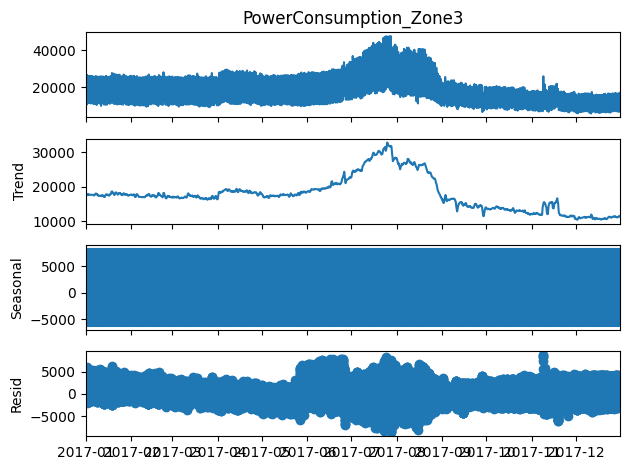

In [23]:
# seasonal decompose
result = seasonal_decompose(df['PowerConsumption_Zone3'], model= 'additive', period= 144)
result.plot()
plt.show()

In [24]:
# adfuller test function
def perform_adftest(data):
    adf_test = adfuller(data, autolag= 'AIC')
    return pd.Series(adf_test[:4], index= ['test_statistics', 'p-value', 'lag', 'samples'])

# calling adfuller test function
perform_adftest(df['PowerConsumption_Zone3'])

test_statistics   -1.636687e+01
p-value            2.835133e-29
lag                5.800000e+01
samples            5.235700e+04
dtype: float64

In [25]:
# reduce dataset
df = df.resample('D').mean()

# split dataset
train = df.iloc[:(df.shape[0] // 2)]
test = df[(df.shape[0] // 2):]
print("Train set:", train.shape[0])
print("Test set:", test.shape[0])

# setting feature and target
x_train = train.drop(columns= "PowerConsumption_Zone3")
y_train = train['PowerConsumption_Zone3']
x_test = train.drop(columns= "PowerConsumption_Zone3")
y_test = test['PowerConsumption_Zone3']

# scale dataset
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Train set: 182
Test set: 182


In [26]:
# build model
model = SARIMAX(y_train, exog= x_train, order= (3, 1, 3), seasonal_order= (1, 1, 1, 144))
result = model.fit(disp= False)

# prediction
forecast_step = test.shape[0]
prediction = result.get_forecast(steps= forecast_step, exog= x_test)
y_predict = prediction.predicted_mean

# model performance
mae = metrics.mean_absolute_error(y_test, y_predict)
rmse = metrics.root_mean_squared_error(y_test, y_predict)
r2 = metrics.r2_score(y_test, y_predict)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Absolute Error: {rmse:.2f}')
print(f'R2 score: {r2:.2f}')

Mean Absolute Error: 8797.42
Root Mean Absolute Error: 9603.48
R2 score: -1.01


In [27]:
# split dataset
x = df.drop(columns= "PowerConsumption_Zone3")
y = df['PowerConsumption_Zone3']

# model retraining
model = SARIMAX(y, exog= x, order= (3, 1, 3), seasonal_order= (1, 1, 1, 144))
result = model.fit(disp= False)

In [36]:
# preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), df.drop(columns= "PowerConsumption_Zone3").columns.to_list())
])

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', result)
])

# save model
model_name = "model.pkl"
with open(model_name, 'wb') as f:
    cloudpickle.dump(pipeline, f)
print(f'model saved as {model_name}')

model saved as model.pkl


In [ ]:
# save everything
save_session()

Session loaded from variables.session
